In [20]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [21]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [29]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, insert, func, distinct, inspect, text

In [23]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)
# reflect the tables


In [25]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [26]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)


In [32]:
measurement_columns = inspector.get_columns('Measurement')
for column in measurement_columns:
    print(column['name'], column['type']) 


NameError: name 'inspector' is not defined

In [ ]:
station_columns = inspector.get_columns('Station')
for column in station_columns:
    print(column['name'], column['type']) 

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [ ]:
# Find the most recent date in the data set.
session.query(func.max(Measurement.date)).scalar()

'2017-08-23'

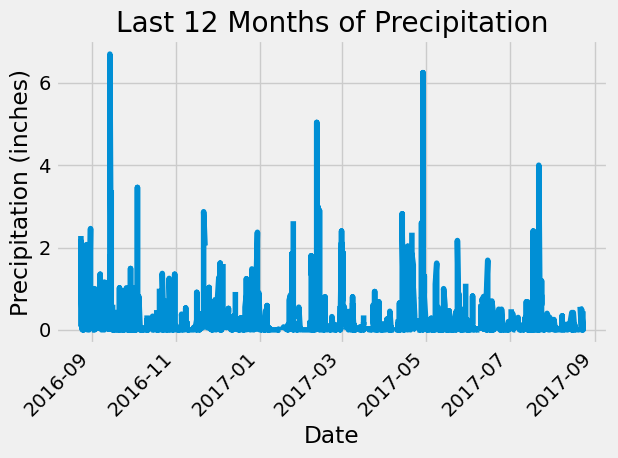

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

latest_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = pd.to_datetime(latest_date) - pd.DateOffset(days=365)

# Perform a query to retrieve the data and precipitation scores for the last 12 months
results = session.query(Measurement.date, Measurement.prcp ).\
    filter(text(f"date >= '{one_year_ago}'")).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date
df.sort_values(by='Date', inplace=True)

# Plot the data using Pandas Plotting with Matplotlib
df.plot(x='Date', y='Precipitation', kind='line', title='Last 12 Months of Precipitation', legend=None)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Perform a query to retrieve the precipitation data
precipitation = df['Precipitation']
# Save the query results as a Pandas DataFrame
precipitation.describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).scalar()

9

In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
usc00519281_stats = session.query(
    func.max(Measurement.tobs),
    func.min(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == 'USC00519281').all()
usc00519281_stats


[(85.0, 54.0, 71.66378066378067)]

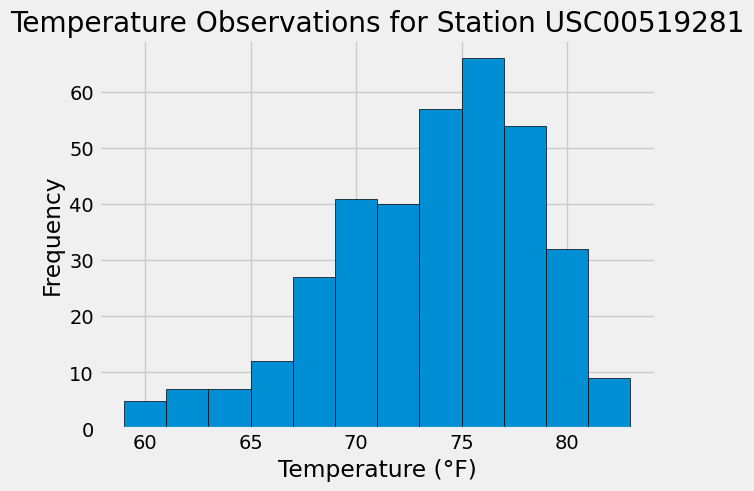

In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(Measurement.station, func.count().label('row_count')).\
    group_by(Measurement.station).\
    order_by(func.count().desc()).first()[0]

latest_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station).scalar()
one_year_ago = (pd.to_datetime(latest_date) - pd.DateOffset(days=365)).strftime('%Y-%m-%d')


results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()


df_temperature = pd.DataFrame(results, columns=['Date', 'Temperature'])


df_temperature['Date'] = pd.to_datetime(df_temperature['Date'])

plt.hist(df_temperature['Temperature'], bins=12, edgecolor='black')
plt.title(f'Temperature Observations for Station {most_active_station}')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [ ]:
# Close Session
session.close()